In [4]:
%load_ext autoreload
%autoreload 2

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

<h1>Checking for Outliers</h1>

The meteostat data comes already structured and standardised, but it's still possible that there may be outliers or other inaccurate measurements in the dataset. Correctly identifying these, however, will be a very difficult task as extreme weather events are possible.

To assess this risk, and to test different methods for detecting potentially erroneous data, we're going to look at a couple of weather stations: one near sea level and close to the equator (reduced seasonal variation), and one at high altitude and latitude (naturally higher variation).

In [3]:
import meteostat

stations = meteostat.Stations().fetch()
stations

# select stations with hourly data
stations = stations[(~stations["hourly_start"].isnull()) & (~stations["hourly_end"].isnull())]
# select stations with at least 20 years of continuous data, up to 2024
stations = stations[(stations["hourly_start"].dt.year<=2004) & (stations["hourly_end"].dt.year==2024)]

# select low latitude and low elevation stations
stations[(abs(stations["elevation"])<10.) & (abs(stations["latitude"])<10.)]

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
43352,Alapuzha,IN,KL,43352,<NA>,9.5500,76.4167,2.0,Asia/Kolkata,1944-07-01,2024-09-14,NaT,NaT,NaT,NaT
43353,Cochin / Willingdon,IN,KL,43353,VOCC,9.9500,76.2667,1.0,Asia/Kolkata,1944-01-01,2024-09-25,NaT,NaT,NaT,NaT
43361,Tondi,IN,TN,43361,<NA>,9.7333,79.0333,4.0,Asia/Kolkata,2003-07-27,2024-09-17,1959-06-15,2024-11-17,1959-01-01,2021-01-01
43367,Car Nicobar,IN,AN,43367,<NA>,9.1667,92.8333,9.0,Asia/Kolkata,1973-01-01,2024-09-14,NaT,NaT,NaT,NaT
43369,Minicoy,IN,LD,43369,<NA>,8.3000,73.1500,1.0,Asia/Kolkata,1944-01-01,2024-09-17,1961-01-12,2024-11-16,1949-01-01,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98836,Zamboanga,PH,ZSI,98836,RPMZ,6.9000,122.0667,5.0,Asia/Manila,1945-03-12,2024-11-25,1945-03-12,2024-11-17,1945-01-01,2022-01-01
AYMO0,Momote,PG,MN,<NA>,AYMO,-2.0500,147.4333,8.0,Pacific/Port_Moresby,2004-07-13,2024-03-19,2005-01-02,2013-12-02,2012-01-01,2012-01-01
MPBO0,Bocas Del Toro / La Cabaña,PA,BT,<NA>,MPBO,9.3500,-82.2500,3.0,America/Panama,1973-01-02,2024-11-24,NaT,NaT,NaT,NaT


Even after selecting on parameters we have 135 options. I'm going to choose **Minicoy**, an Indian territory, as it has a very good temporal coverage for hourly, daily, and monthly, although the last two are not strictly required here. 

For our other station, we need to be a little bit more mindful. It's easy to classify a station as sea-level or low-latitude, as these values are defined at zero. However, to classify a location as *high* altitude or latitude, we have to face an open boundary at the other end, and this can cause issues that we will see shortly. 

To begin with, we'll have a look at the distribution of latitude, bearing in mind that 0° is the equator, and +/- 90° corresponds to the poles.

Text(0.5, 0, 'Latitude, °')

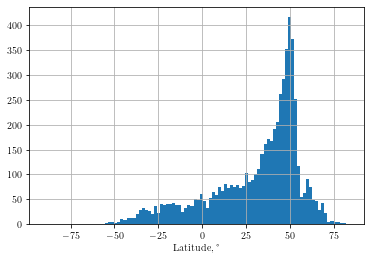

In [6]:
stations["latitude"].hist(bins=100).set_xlabel("Latitude, °");

We have no values >90° or <-90°, so that's good. We can also see that the majority of stations lie in the Northern Hemisphere (positive latitude), which makes sense as much of the Southern Hemisphere is taken up by ocean.

Now let's look at the elevation data.

Text(0.5, 0, 'Elevation above sea level, m')

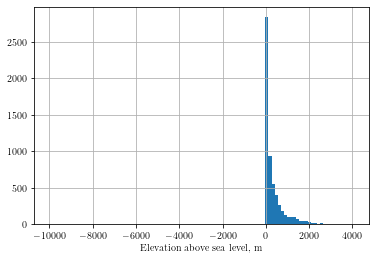

In [7]:
stations["elevation"].hist(bins=100).set_xlabel("Elevation above sea level, m");

And "oops", it looks like we have at least one station with an elevation of close to -10,000m, which is... unlikely. There seems to be a rather hard cutoff at 0m (which is reasonable), so we can have a look at all stations with negative elevation to check how many are impacted.

In [8]:
stations[stations["elevation"]<0.]

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
06240,Amsterdam Airport Schiphol,NL,NH,06240,EHAM,52.3000,4.7667,-4.0,Europe/Amsterdam,1932-05-03,2024-11-25,1973-01-02,2022-04-25,1974-01-01,2022-01-01
06249,Berkenhout / Berkhout,NL,NH,06249,<NA>,52.6428,4.9789,-2.0,Europe/Amsterdam,2001-07-02,2024-11-05,2001-09-20,2022-03-26,2007-01-01,2020-01-01
06273,Marknesse Aws,NL,FL,06273,<NA>,52.7000,5.8833,-3.0,Europe/Amsterdam,1994-09-01,2024-11-05,2000-10-06,2022-02-09,2006-01-01,2018-01-01
06344,Rotterdam Airport Zestienhoven,NL,ZH,06344,EHRD,51.9500,4.4500,-5.0,Europe/Amsterdam,1957-01-01,2024-11-25,1973-01-02,2022-04-25,1977-01-01,2022-01-01
34798,Ganjushkino,KZ,ATY,34798,<NA>,46.6000,49.2667,-22.0,Asia/Aqtau,1959-01-01,2024-11-13,1936-01-01,1991-12-31,1936-01-01,1991-01-01
35700,Atyray,KZ,ATY,35700,<NA>,47.1000,51.7167,-15.0,Asia/Aqtau,1932-01-01,2024-11-13,1881-01-01,2024-11-15,1881-01-01,2021-01-01
37864,Baku / Bine Airport,AZ,<NA>,37864,UBBB,40.4500,50.0667,-6.0,Asia/Baku,1959-04-02,2024-11-25,2000-04-12,2022-04-25,2009-01-01,2022-01-01
38232,Akkuduk,KZ,MAN,38232,<NA>,42.9667,54.1167,-79.0,Asia/Aqtau,1957-07-01,2024-09-11,1949-11-01,2021-03-10,1949-01-01,2021-01-01
40296,Ghor El Safi,JO,KA,40296,<NA>,31.0333,35.4667,-350.0,Asia/Amman,1983-07-01,2024-11-14,1983-07-02,2024-11-14,1985-01-01,2021-01-01


Of the above, only two really catch the eye: Ghor El Safi in Jordan at -350m and Manihiki Island / Tukao in the Cook Islands at -9999m. The latter is obviously an invalid value, as the Cook Islands are (as the name suggests) a series of islands making -9999m very unreasonable. Ghor El Safi, though, is actually correct! Located in the Jordan Valley, it's the lowest point of dry land on Earth. 

In our case we're more interested in high elevation, however it's still important to consider the potential for incorrect data. So let's have a look at the higher elevations:

In [9]:
stations[stations["elevation"]>3000.]

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
16052,Pian Rosa,IT,AO,16052,LIMH,45.9333,7.7000,3480.0,Europe/Rome,1965-01-29,2024-11-25,1965-04-28,2024-11-17,1966-01-01,2022-01-01
36982,Tian-Shan,KG,YK,36982,<NA>,41.8833,78.2333,3635.0,Asia/Bishkek,1959-01-01,2024-11-13,1930-01-01,2024-11-07,1930-01-01,2021-01-01
55591,Lhasa,CN,XZ,55591,ZULS,29.6667,91.1333,3650.0,Asia/Urumqi,1956-08-20,2024-11-12,1955-01-01,2024-11-12,1955-01-01,2022-01-01
84088,Izobamba-Santa Catalina,EC,P,84088,<NA>,-0.3667,-78.5500,3058.0,Pacific/Galapagos,2001-09-21,2024-07-27,2005-09-20,2024-12-30,1975-01-01,2021-01-01
84226,Canar,EC,F,84226,<NA>,-2.5500,-78.9333,3120.0,Pacific/Galapagos,1973-01-01,2024-07-25,1973-01-01,2024-12-17,1973-01-01,2021-01-01
84686,Cuzco,PE,CU,84686,SPZO,-13.5500,-71.9833,3248.0,America/Lima,1949-03-03,2024-11-25,1963-01-03,2024-12-17,1953-01-01,2022-01-01
84688,Andahuayla,PE,AP,84688,SPHY,-13.7167,-73.3500,3444.0,America/Lima,1994-04-01,2024-11-24,NaT,NaT,1999-01-01,2001-01-01
84735,Juliaca,PE,PU,84735,SPJL,-15.4833,-70.1500,3826.0,America/Lima,1961-03-08,2024-11-25,1963-01-03,2024-10-27,1962-01-01,2021-01-01
85201,La Paz / Alto,BO,L,85201,SLLP,-16.5167,-68.1833,4058.0,America/La_Paz,1936-04-01,2024-11-25,1942-06-01,2024-12-30,1942-01-01,2022-01-01


This all looks good from here, so let's go with **Cuzco**, Peru.

With our two stations selected, we can now look at the distribution of weather variables.

array([[<Axes: title={'center': 'temp'}, xlabel='city'>,
        <Axes: title={'center': 'rhum'}, xlabel='city'>],
       [<Axes: title={'center': 'prcp'}, xlabel='city'>,
        <Axes: title={'center': 'wspd'}, xlabel='city'>],
       [<Axes: title={'center': 'pres'}, xlabel='city'>, <Axes: >]],
      dtype=object)

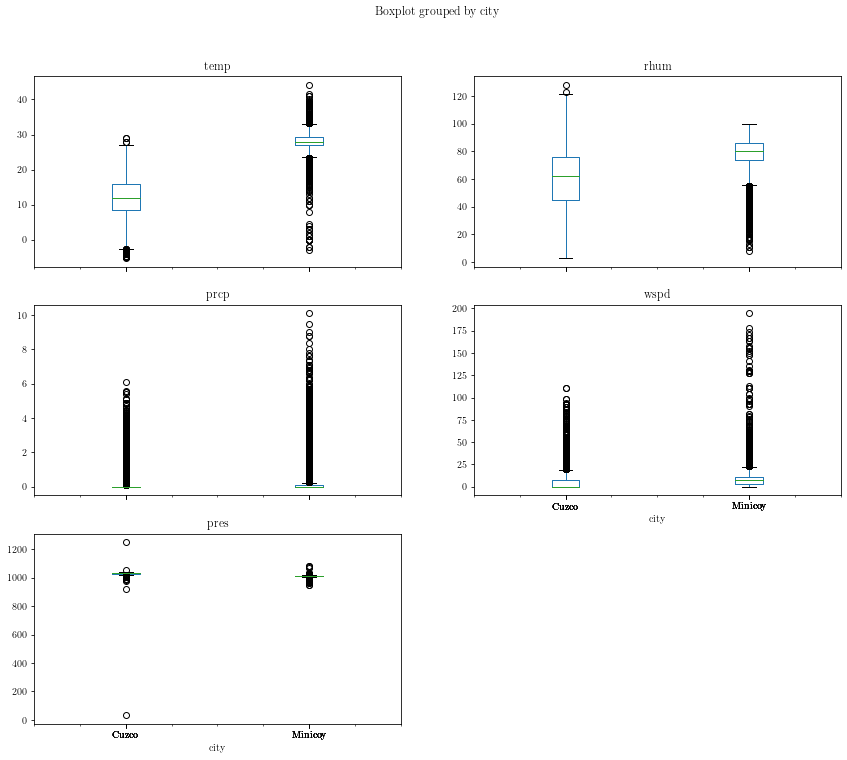

In [56]:
import pandas as pd

minicoy_loc = stations[stations["name"]=="Minicoy"]
start = minicoy_loc["hourly_start"].iloc[0]
end = minicoy_loc["hourly_end"].iloc[0]
minicoy_df = meteostat.Hourly(minicoy_loc, start, end).fetch()

cuzco_loc = stations[stations["name"]=="Cuzco"]
start = cuzco_loc["hourly_start"].iloc[0]
end = cuzco_loc["hourly_end"].iloc[0]
cuzco_df = meteostat.Hourly(cuzco_loc, start, end).fetch()

df = pd.concat([minicoy_df,cuzco_df], keys=["Minicoy", "Cuzco"], names=["city"])

df.boxplot(figsize=(14, 12), column=['temp', 'rhum', 'prcp', 'wspd', 'pres'], by="city",
                  grid=False, sharey=False);

And we can see that these two stations have quite different distributions of the variables we're interested in. Minicoy has a tropical wet and dry type climate, and so has relatively little seasonal variation and sees slightly less rainfall than a tropical monsoon climate, while Cuzco has a subtropical highland climate with two well-defined seasons.

We can also see how a simple 1.5 interquartile range (what the whiskers on the boxplot show) is often inadequate for identifying outliers in weather data. Some outliers, like the ~0hPa pressure reading for Cuzco, may be obviously aberrant, but there is otherwise a smooth spread of data points beyond the 1.5IQR which may simply represent uncommon extreme events like storms. 

When thinking about weather variables, as long as there is a smooth and continuous variation from one data point to the next, we can assume it's likely correct (bar any normalisation errors). So what we really care about in outlier detection is the *rate of change* of each variable:

In [57]:
diff = df.groupby("city").diff()
diff

temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
city    time                                                                   
Minicoy 1944-01-01 12:00:00   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   
        1944-01-02 03:00:00  -1.1  -0.1   4.0   NaN   NaN    0.0   0.0   NaN   
        1944-01-02 12:00:00   0.6   0.5   0.0   NaN   NaN  -30.0   0.0   NaN   
        1944-01-03 03:00:00  -0.6   0.5   5.0   NaN   NaN   70.0  -5.8   NaN   
        1944-01-03 12:00:00  -2.2  -0.9   6.0   NaN   NaN  -70.0   0.0   NaN   
...                           ...   ...   ...   ...   ...    ...   ...   ...   
Cuzco   2024-11-24 20:00:00  -3.0  -0.2  11.0   1.0   NaN  160.0   5.0   NaN   
        2024-11-24 21:00:00  -1.0   0.1   5.0  -1.7   NaN  -30.0  -9.0   NaN   
        2024-11-24 22:00:00   0.0   0.0   0.0   1.8   NaN -170.0   0.0   NaN   
        2024-11-24 23:00:00  -1.0   0.1   5.0  -2.0   NaN   30.0   2.0   NaN   
        2024-11-25 00:00:00  -1.0  -0.1   5.0   0.0   NaN  160.0  -7.0   NaN   

                             pres  tsun  coco  
city    time                                   
Minicoy 1944-01-01 12:00:00   NaN   NaN   NaN  
        1944-01-02 03:00:00   1.9   NaN   NaN  
        1944-01-02 12:00:00  -7.6   NaN   NaN  
        1944-01-03 03:00:00   7.4   NaN   NaN  
        1944-01-03 12:00:00  -1.0   NaN   NaN  
...                           ...   ...   ...  
Cuzco   2024-11-24 20:00:00   0.0   NaN   0.0  
        2024-11-24 21:00:00   0.0   NaN   0.0  
        2024-11-24 22:00:00   0.0   NaN   0.0  
        2024-11-24 23:00:00   1.0   NaN   0.0  
        2024-11-25 00:00:00   2.0   NaN   0.0  

[559057 rows x 11 columns]

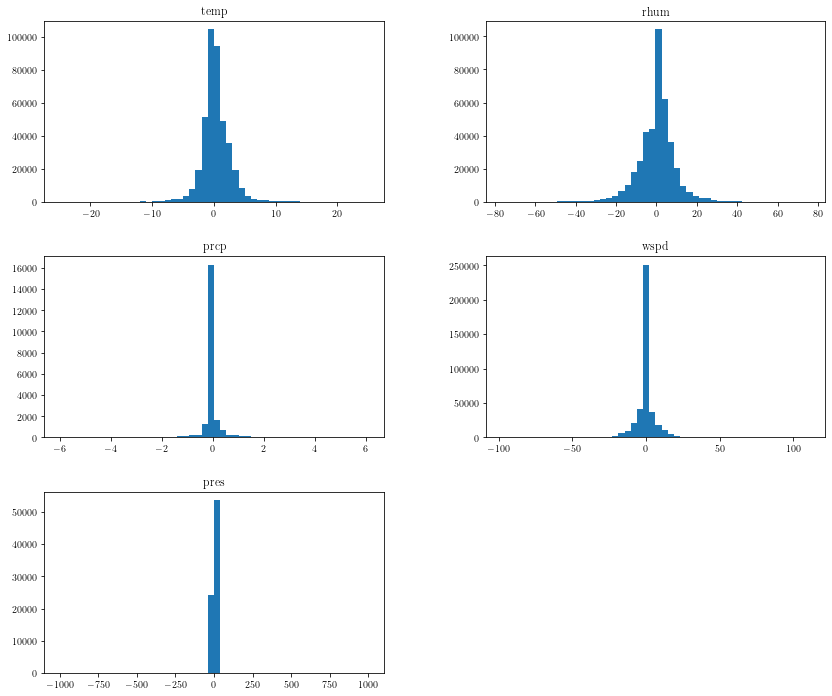

In [235]:
diff.loc["Cuzco"].hist(figsize=(14, 12), bins=50, column=['temp', 'rhum', 'prcp', 'wspd', 'pres'],
                 grid=False);

The above histograms show the distribution of *difference* data, i.e. the difference between any given reading and the one immediately before it. This tightens the distribution significantly for the pressure, and we can see clearly that extreme outliers here are erroneous:

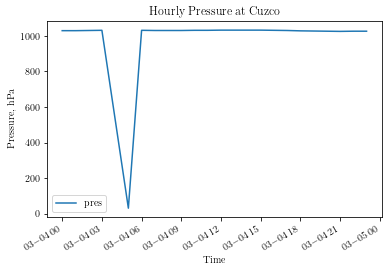

In [62]:
from datetime import datetime

max_pdiff = diff.loc["Cuzco"]["pres"].max()
outlier = diff.loc["Cuzco"].index[diff.loc["Cuzco"]["pres"] == max_pdiff]

filtered_data = df[((df.index.get_level_values('city') == 'Cuzco')) & (df.index.get_level_values('time').date == outlier.date[0])]

plot = filtered_data.loc["Cuzco"].plot(y="pres", title=f"Hourly Pressure at Cuzco",
                          xlabel="Time", ylabel="Pressure, hPa")

So the pressure value taken around 5am is about 1000hPa below the values immediately beside it.

But the distributions for other variables are less confined, and we have more extended wings on the histograms that may indicate something else is going on, as we know, for example, that a change of +/-10°C within one hour would be rather extreme. 

So let's have a look at one of these extreme temperature changes and see what's going on.

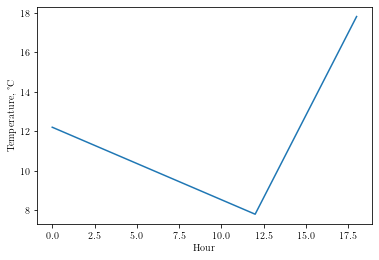

In [212]:
import matplotlib.pyplot as plt

# find dataframe entry of an outlier
outlier = diff.loc["Cuzco"].index[diff.loc["Cuzco"]["temp"] == 10.]

# get data for day of outlier
filtered_data = df[((df.index.get_level_values("city") == "Cuzco")) & (df.index.get_level_values("time").date == outlier.date[0])]

plt.plot(filtered_data.loc["Cuzco"].index.hour, filtered_data["temp"])
plt.xlabel("Hour");
plt.ylabel("Temperature, °C");

And now we can see where some of these high variations are coming from! Data has not been reliably recorded for every hour, so the difference between adjacent recordings can be large even if the slope is not particularly extreme. It's now clear that we will have to take the time of recordings into account when calculating the slope, rather than doing a simple arithmetic difference.

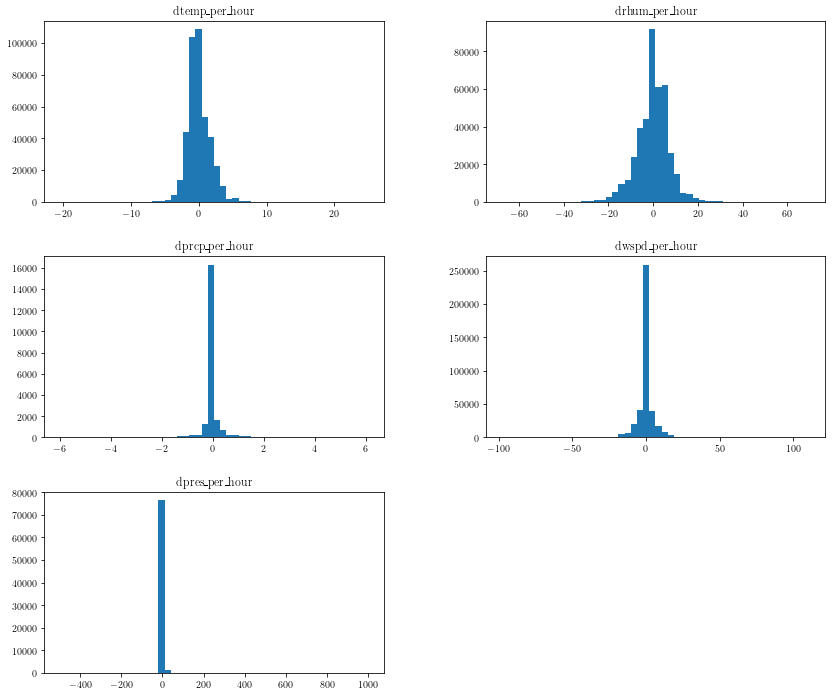

In [214]:
cuzco_hours_passed = cuzco_df.index.to_series().diff().dt.days*24. + cuzco_df.index.to_series().diff().dt.seconds//3600
minicoy_hours_passed = minicoy_df.index.to_series().diff().dt.days*24. + minicoy_df.index.to_series().diff().dt.seconds//3600

for var in ["temp","rhum","prcp","wspd","pres"]:
    cuzco_df[f'd{var}_per_hour'] = cuzco_df[f'{var}'].diff() / cuzco_hours_passed
    minicoy_df[f'd{var}_per_hour'] = minicoy_df[f'{var}'].diff() / minicoy_hours_passed
    
df = pd.concat([minicoy_df,cuzco_df], keys=["Minicoy", "Cuzco"], names=["city"])

df.loc["Cuzco"].hist(figsize=(14, 12), bins=50, 
                     column=['dtemp_per_hour', 'drhum_per_hour', 'dprcp_per_hour', 'dwspd_per_hour', 'dpres_per_hour'],
                     grid=False);

This has reduced the spread of data somewhat, indicating that the spurious outliers we picked up before due to incomplete time data have now been resolved.

We can see this if we now look at all days with a (positive) temperature variation >13°C, with the offending measurement shown with a dot:

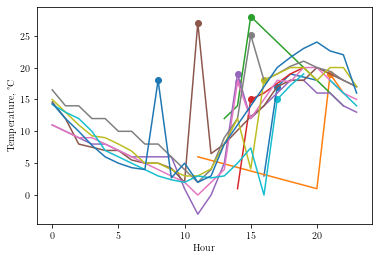

In [213]:
import matplotlib.dates as mdates

# find dataframe entry of an outlier
max_dtemp_var = df.loc["Cuzco"]["dtemp_per_hour"].max()
max_dtemp_var = 10
outlier = df.loc["Cuzco"].index[df.loc["Cuzco"]["dtemp_per_hour"] > 13.]
outlier_dates = pd.to_datetime(outlier.date).date
outlier_times = outlier.time

# get data for day of outlier
df['date'] = df.index.get_level_values("time").date
filtered_data = df[((df.index.get_level_values("city") == "Cuzco")) &
                   (df['date'].isin(outlier_dates))]

for key, grp in filtered_data.groupby(["date"]):
    plt.plot(grp.loc["Cuzco"].index.hour, grp["temp"]);

    outlier_dt = outlier[outlier.date == key][0]
    outlier_entry = grp.xs(key=outlier_dt, level="time");

    plt.scatter(outlier_dt.hour, outlier_entry["temp"]);
    
plt.xlabel("Hour");
plt.ylabel("Temperature, °C");

So we can accurately identify where there are outliers! This method of detection has one significant weakness in that it may misidentify the point *after* as being the outlier if the real outlier lies below the correct curve (see the orange line). Hence, in order to identify true outliers more accurately than we have here, we would need to take into account the preceeding data, most likely utilising a moving window average. This could become quite complex as we may encounter sparse data with inconsistent spacing. Hence this method is certainly possible, but given the large amounts of data we want to process, and the courseness with which we want to process it (e.g. looking for number of days with high variation), we can likely afford to simply wholesale discard individual days on which there is an outlier.

One thing not mentioned above but which will be very important in identifying outliers is to define a threshold for the slope in each variable. In our case, it will probably suffice to simply use the Interquartile Range on our difference columns. Normally this would be a range of +/- 1.5IQR but from experience this tends to be rather narrow, so I'm going to extend it to +/- 3IQR to have fewer false positives.

In [238]:
statistics = df.groupby("city").describe()
intr_qr = statistics["dtemp_per_hour"]["75%"] - statistics["dtemp_per_hour"]["25%"]
maxq = statistics["dtemp_per_hour"]["75%"] + (3*intr_qr)
minq = statistics["dtemp_per_hour"]["25%"] - (3*intr_qr)

print(f"Acceptable dtemp_per_hour range for Cuzco: ({minq['Cuzco']}, {maxq['Cuzco']})°C")
print(f"Acceptable dtemp_per_hour range for Minicoy: ({minq['Minicoy']}, {maxq['Minicoy']})°C")

Acceptable dtemp_per_hour range for Cuzco: (-7.0, 7.0)°C
Acceptable dtemp_per_hour range for Minicoy: (-2.133333333333334, 2.0666666666666678)°C


And as an added bonus, we can now more clearly see the effect that altitude has on weather variation, with the high altitude, high latitude Cuzco having a much larger temperature variation range than Minicoy! This is a good example of why we need to set thresholds on a per-station basis, as a simple uniform threshold of e.g. 2°C would correctly identify most outliers in Minicoy but flag likely correct data in Cuzco. 